In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = pd.read_csv('../input/train.csv')

In [4]:
train_data.shape

(9557, 143)

Text(0.5, 1.0, 'Count of Unique values in Integer Columns')

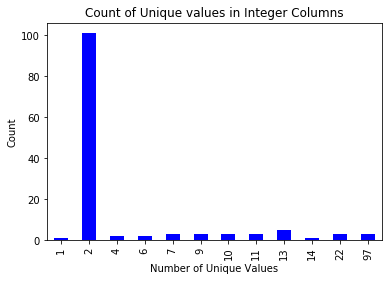

In [5]:
train_data.select_dtypes(include=[np.int64]).nunique().value_counts().sort_index().plot.bar(color='blue');
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique values in Integer Columns')

In [6]:
train_data.select_dtypes(include = ['object']).head()
    

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


dependency: Dependency rate, calculated = (No. of members of the household younger than 19 or older tahn 64)/(No of 
            members of household between 19 and 64)
edjefe: years of education of male head of household, "yes" = 1 and "no" = 0
edjefa: years of education of female head of household, "yes" = 1 and "no" = 0

Replace 'yes' with 1 and 'no' with 0 in all the above 3 columns for 'train' and 'test' data

In [7]:
def ProcessObjectTypeColumns(df):
    replacements = {'yes':1,'no':0}
    df['dependency'].replace(replacements,inplace=True)
    df['edjefe'].replace(replacements,inplace=True)
    df['edjefa'].replace(replacements,inplace=True)
    #Now all the 'object' columns have 'float' data. So, convert these columns to 'float' datatype
    df['dependency'] = pd.to_numeric(df['dependency'])
    df['edjefe'] = pd.to_numeric(df['edjefe'])
    df['edjefa'] = pd.to_numeric(df['edjefa'])
    return df

In [8]:
train_data = ProcessObjectTypeColumns(train_data)

Distribution of poverty levels in the training data

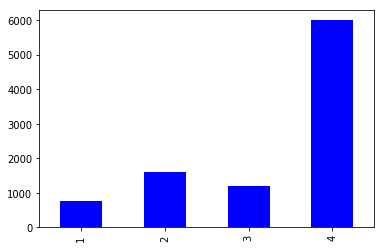

In [9]:
train_data['Target'].value_counts().sort_index().plot.bar(color='blue')

The poverty level should be same for each individual in a household. Let's check whether each member of the household has same poverty level. As per the given data, the 'idhogar' field is a unique identifier for each household. We will make use of this field to identify if there are any anomolies

In [10]:
all_equal = train_data.groupby('idhogar')['Target'].apply(lambda x:x.nunique() == 1)
not_equal = all_equal[all_equal != True]
print('There are {} households where the poverty level is not same for all members'.format(len(not_equal)))

There are 85 households where the poverty level is not same for all members


For all these households we can take the poverty level of head of the household as poverty level. But before that let's check if there are any households without a head of the household

In [11]:
head_of_household  = train_data.groupby('idhogar')['parentesco1'].sum()
households_no_head = train_data.loc[train_data['idhogar'].isin(head_of_household[head_of_household == 0].index),:]
print('There are {} households without a head of household'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head of household


For the records where there is a difference in poverty level within the household members, lets update them with the poverty level of head of the household

In [13]:
for household in not_equal.index:
    actual_target = int(train_data[(train_data['idhogar'] == household)&(train_data['parentesco1']) == 1.0]['Target'])
    train_data.loc[train_data['idhogar']==household,'Target'] = actual_target

Find the missing values in each column

In [14]:
missing_values = train_data.isnull().sum().sort_values(ascending = False)
missing_values[missing_values != 0]

rez_esc      7928
v18q1        7342
v2a1         6860
meaneduc        5
SQBmeaned       5
dtype: int64

The above data shows missing values are in the columns 'rez_esc', 'v18q1', 'v2a1', 'meaneduc', 'SQBmeaned'
'rez_esc': Years behind in school
'v18q1': number of tablets household owns
'v2a1': Monthly rent payment
'meaneduc': average years of education for adults (18+)
'SQBmeaned': square of the mean years of education of adults (>=18) in the household

In [15]:
def ReplaceMissingDatawithMean(df):
    df['rez_esc'].fillna((df['rez_esc'].mean()),inplace=True)
    df['v18q1'].fillna((df['v18q1'].mean()),inplace=True)
    df['v2a1'].fillna((df['v2a1'].mean()),inplace=True)
    df['meaneduc'].fillna((df['meaneduc'].mean()),inplace=True)
    df['SQBmeaned'].fillna((df['SQBmeaned'].mean()),inplace=True)
    return df

In [16]:
train_data = ReplaceMissingDatawithMean(train_data)

We can neglect the features 'Id' and 'idhogar' as they are just identifiers

In [17]:
X = train_data[train_data.columns.difference(['Id','idhogar','Target'])].copy()
y = train_data['Target']

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


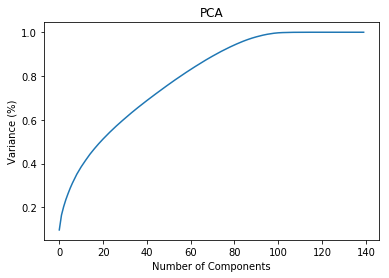

In [19]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('PCA')
plt.show()

From the above plot it is clear that if we take 80 components we can preserve atleast 90 % variance. So we will choose components

In [20]:
pca = PCA(n_components = 80)
X = pca.fit_transform(X)

In [21]:
df = pd.DataFrame(data = X)

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(df,y,test_size=0.3)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

**Gradient Boosting Classifier:**

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gbclf = GradientBoostingClassifier()
gbclf.fit(X_train,y_train)
y_gbclf = gbclf.predict(X_val)
cm_gbclf = confusion_matrix(y_val,y_gbclf)
cm_gbclf

array([[  65,   42,   13,  119],
       [   9,  200,   15,  232],
       [  10,   56,   55,  251],
       [  11,   55,   13, 1722]])

In [25]:
score_gbclf = accuracy_score(y_val,y_gbclf)
score_gbclf

0.7119944211994421

**Random Forest Classifier:**

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()
rfclf.fit(X_train,y_train)
y_rfclf = rfclf.predict(X_val)
cm_rfclf = confusion_matrix(y_val,y_rfclf)
cm_rfclf

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[  93,   38,    8,  100],
       [  17,  214,   23,  202],
       [  15,   47,   94,  216],
       [  18,   83,   44, 1656]])

In [27]:
score_rfclf = accuracy_score(y_val,y_rfclf)
score_rfclf

0.7172245467224547

**KNeighbors Classifier:**

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knclf = KNeighborsClassifier()
knclf.fit(X_train,y_train)
y_knclf = knclf.predict(X_val)
cm_knclf = confusion_matrix(y_val,y_knclf)
cm_knclf

array([[ 117,   32,   18,   72],
       [  19,  268,   24,  145],
       [  13,   54,  168,  137],
       [  36,   90,   65, 1610]])

In [29]:
score_knclf = accuracy_score(y_val,y_knclf)
score_knclf

0.75418410041841

**Extra Tress Classifier:**

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
etclf = ExtraTreesClassifier()
etclf.fit(X_train,y_train)
y_etclf = etclf.predict(X_val)
cm_etclf = confusion_matrix(y_val,y_etclf)
cm_etclf

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[  99,   28,   12,  100],
       [  11,  209,   17,  219],
       [  14,   31,  105,  222],
       [  13,   64,   27, 1697]])

In [31]:
score_etclf = accuracy_score(y_val,y_etclf)
score_etclf

0.7357043235704324

**XGBoost Classifier:**

In [32]:
from xgboost import XGBClassifier
xgclf = XGBClassifier()
xgclf.fit(X_train,y_train)
y_xgclf = xgclf.predict(X_val)
cm_xgclf = confusion_matrix(y_val,y_xgclf)
cm_xgclf

array([[  57,   42,    6,  134],
       [   6,  183,    2,  265],
       [   4,   59,   39,  270],
       [   9,   59,    5, 1728]])

In [33]:
score_xgclf = accuracy_score(y_val,y_xgclf)
score_xgclf

0.6997907949790795

**Light GBM Classifier:**

In [44]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train,label=y_train)
params={}
lgbclf = lgb.train(params,d_train,100)
y_lgbclf = lgbclf.predict(X_val)

**Predicting Poverty levels for Test Data**

In [45]:
test_data = pd.read_csv('../input/test.csv')

In [47]:
test_data = ProcessObjectTypeColumns(test_data)

In [48]:
test_data = ReplaceMissingDatawithMean(test_data)

In [49]:
X_test = test_data[test_data.columns.difference(['Id','idhogar'])].copy()
X_test = scaler.fit_transform(X_test)
X_test = pca.fit_transform(X_test)
X_test = pd.DataFrame(data = X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


We will choose KNeighbors Classifier for preducting the test data poverty levels as it has given 75 % accuracy

In [50]:
y_test_knclf = knclf.predict(X_test)

In [52]:
test_data['Target'] = pd.Series(y_test_knclf)

In [53]:
test_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,174872.554316,0,5,0,1,1,0,1.348517,1,1,2,0,1,1,1,2,3,3,3,0,0.425172,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,16.500000,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25000,16,4
1,ID_1c78846d2,174872.554316,0,5,0,1,1,0,1.348517,1,1,2,0,1,1,1,2,3,3,3,16,0.425172,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,16.500000,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25000,1681,4
2,ID_e5442cf6a,174872.554316,0,5,0,1,1,0,1.348517,1,1,2,0,1,1,1,2,3,3,3,17,0.425172,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,16.500000,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25000,1681,4
3,ID_a8db26a79,174872.554316,0,14,0,1,1,1,1.000000,0,1,1,0,0,0,0,1,1,1,1,16,0.425172,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,16.000000,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00000,3481,4
4,ID_a62966799,175000.000000,0,4,0,1,1,1,1.000000,0,0,0,0,1,1,0,1,1,1,1,11,0.425172,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,9.157474,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,100.50922,324,4
